# Imports

In [1]:
import random
import time
import numpy as np


import warnings
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2024-06-20 12:40:57.796217: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 12:40:59.577640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
warnings.filterwarnings("ignore")

# Load

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# EDA

In [4]:
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

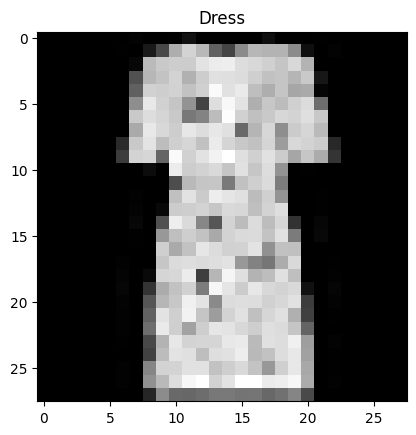

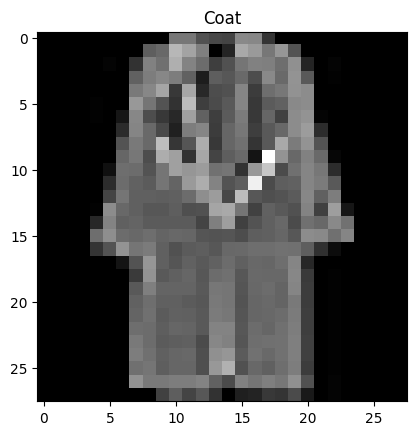

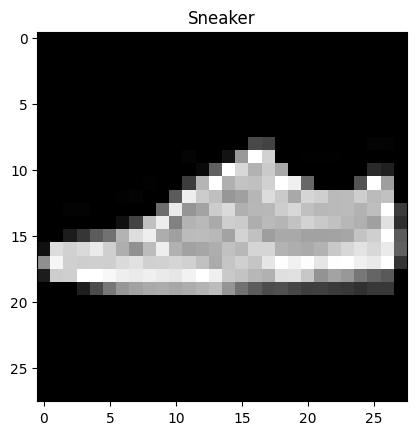

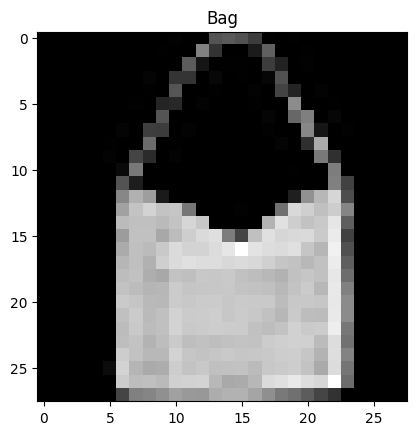

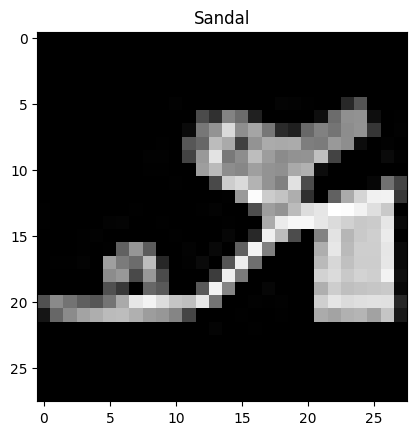

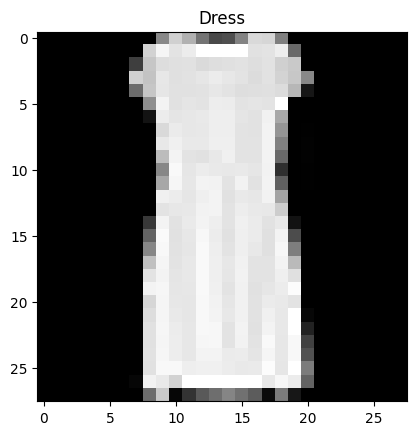

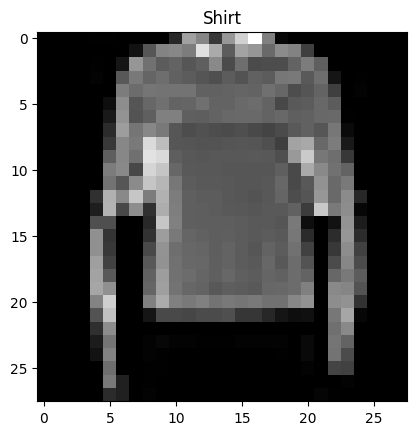

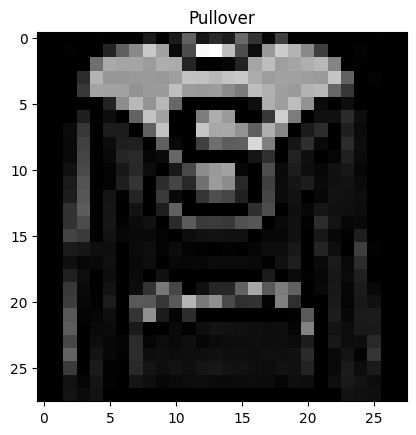

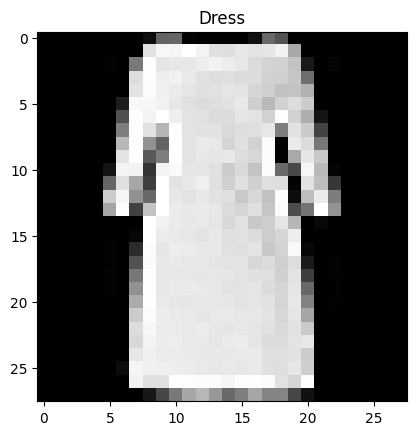

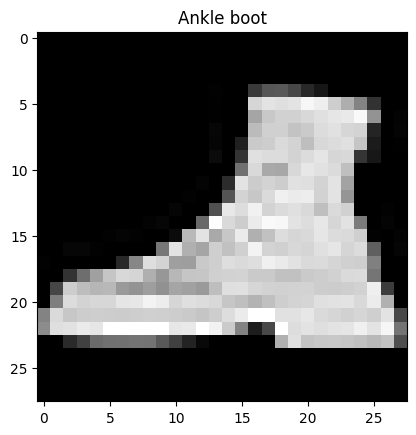

In [5]:
for i in range(10):
    idx = random.randint(0, train_images.shape[0] - 1)
    img = train_images[idx].reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.title(f"{class_names[train_labels[idx]]}")
    plt.show()

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
test_images.shape

(10000, 28, 28)

In [8]:
import pandas as pd
pd.DataFrame(train_labels).value_counts()

0
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

# Preprocessing

In [9]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3500 # максимальне число епох                                          
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів

In [10]:
# Перетворюємо цілочисельні пікселі на тип float32
train_images, test_images = np.array(train_images, np.float32), np.array(test_images, np.float32)

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_images))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

2024-06-20 12:41:04.903954: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-20 12:41:04.905228: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-06-20 12:41:05.332581: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [11]:
train_images_cnn = train_images[..., np.newaxis]
test_images_cnn = test_images[..., np.newaxis]

# HomeWork Part 1

## Model

In [12]:
def plot_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Change')
    ax1.legend()
    
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy change')
    ax2.legend()
    
    plt.show()

#### Simple Model: Adam - Hidden Sigmoid  (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS - 15 epochs,  batch = 2

In [13]:
name_simple_model ='Simple Adam - Hidden Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  15 epochs,  batch = 2'

In [14]:
epochs = 15
batch_size = 2


optimizer = tf.keras.optimizers.Adam(beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-7)

In [15]:
def lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

In [16]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28), name='Flatten'), 
    tf.keras.layers.Lambda(lambda x: x / 255, name='Normalize'), 
    tf.keras.layers.Dense(256, activation='sigmoid', name='Dense1'),
    tf.keras.layers.Dense(128, activation='tanh', name='Dense2'),
    tf.keras.layers.Dropout(0.2, name='Drop1'),
    tf.keras.layers.Dense(64, activation='relu', name='Dense3'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

In [17]:
simple_model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [18]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [19]:
start_simple_model = time.time()

In [20]:
simple_history = simple_model.fit(test_images, test_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        initial_epoch=0,
                        validation_split=0.1,
                        callbacks=[lr_scheduler_callback])

Epoch 1/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.6346 - loss: 0.9791 - val_accuracy: 0.7670 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 2/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.7930 - loss: 0.5554 - val_accuracy: 0.8370 - val_loss: 0.4738 - learning_rate: 0.0010
Epoch 3/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.8205 - loss: 0.4840 - val_accuracy: 0.8030 - val_loss: 0.5681 - learning_rate: 0.0010
Epoch 4/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8294 - loss: 0.4693 - val_accuracy: 0.8440 - val_loss: 0.4514 - learning_rate: 0.0010
Epoch 5/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.8539 - loss: 0.4147 - val_accuracy: 0.8420 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 6/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.8759 - loss: 0.3351 - val_accuracy: 0.8490 - val_loss: 0.4578 - learning_rate: 5.0000e-04
Epoch 7/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy:

In [21]:
end_simple_model  = time.time() - start_simple_model

In [22]:
test_loss_simple_model , test_acc_simple_model  = simple_model.evaluate(test_images,  test_labels)

print('Test accuracy:', test_acc_simple_model)
print('Test loss:', test_loss_simple_model)
print ('Learning time, sec:', f'{end_simple_model:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9335 - loss: 0.1745
Test accuracy: 0.9283999800682068
Test loss: 0.20611250400543213
Learning time, sec: 503.08


In [23]:
simple_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Normalize (Lambda)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,288 (2.78 MB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 485,526 (1.85 MB)

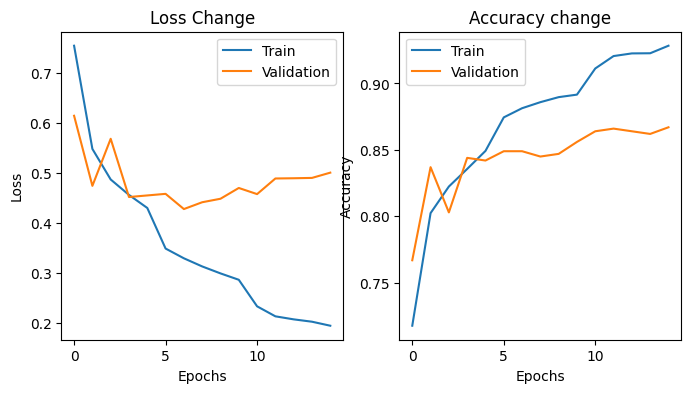

In [24]:
plot_curves(simple_history)

#### CNN Model: Adam - Hidden SConv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigmoid  (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS - 15 epochs,  batch = 2

In [50]:
name_cnn_model ='CNN Adam - Hidden Conv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  15 epochs,  batch = 2'

In [26]:
epochs = 15
batch_size = 2


optimizer = tf.keras.optimizers.Adam(beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-7)

In [27]:
def lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

In [28]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x / 255.,  input_shape=(28, 28, 1), name='Normalize'),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(input_shape=(28, 28), name='Flatten'),  
    tf.keras.layers.Dense(256, activation='sigmoid', name='Dense1'),
    tf.keras.layers.Dense(128, activation='tanh', name='Dense2'),
    tf.keras.layers.Dropout(0.2, name='Drop1'),
    tf.keras.layers.Dense(64, activation='relu', name='Dense3'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

In [29]:
cnn_model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [30]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [31]:
start_cnn_model = time.time()

In [32]:
cnn_history = cnn_model.fit(test_images_cnn, test_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        initial_epoch=0,
                        validation_split=0.1,
                        callbacks=[lr_scheduler_callback])

Epoch 1/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.5629 - loss: 1.1716 - val_accuracy: 0.7620 - val_loss: 0.6151 - learning_rate: 0.0010
Epoch 2/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7724 - loss: 0.5980 - val_accuracy: 0.7980 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 3/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8147 - loss: 0.5019 - val_accuracy: 0.8270 - val_loss: 0.4802 - learning_rate: 0.0010
Epoch 4/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.8400 - loss: 0.4303 - val_accuracy: 0.8350 - val_loss: 0.4302 - learning_rate: 0.0010
Epoch 5/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.8562 - loss: 0.3943 - val_accuracy: 0.8700 - val_loss: 0.4189 - learning_rate: 0.0010
Epoch 6/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.8970 - loss: 0.2843 - val_accuracy: 0.8610 - val_loss: 0.4082 - learning_rate: 5.0000e-04
Epoch 7/15
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy:

In [33]:
end_cnn_model  = time.time() - start_cnn_model

In [34]:
test_loss_cnn_model , test_acc_cnn_model  = cnn_model.evaluate(test_images_cnn,  test_labels)

print('Test accuracy:', test_acc_cnn_model)
print('Test loss:', test_loss_cnn_model)
print ('Learning time, sec:', f'{end_cnn_model:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9804 - loss: 0.0663
Test accuracy: 0.970300018787384
Test loss: 0.11899051815271378
Learning time, sec: 570.59


In [35]:
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Normalize (Lambda)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,776 (2.81 MB)

 Trainable params: 245,258 (958.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 490,518 (1.87 MB)

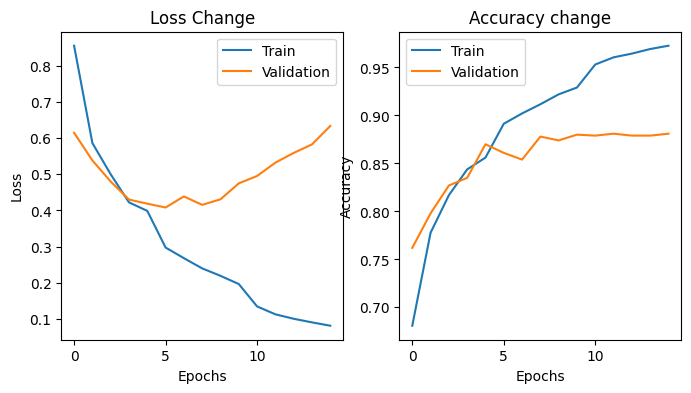

In [36]:
plot_curves(cnn_history)

#### CNN_2 Model: Adam - Hidden Conv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigmoid  (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS - 15 epochs,  batch = 2

In [53]:
name_cnn_2_model ='CNN_2 Adam - Hidden Conv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  30 epochs,  batch = 2'

In [38]:
epochs = 30
batch_size = 2


optimizer = tf.keras.optimizers.Adam(beta_1=0.9, 
                                     beta_2=0.999, 
                                     epsilon=1e-7)

In [39]:
def lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return 0.0005
    else:
        return 0.0001

In [40]:
cnn_2_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x / 255.,  input_shape=(28, 28, 1), name='Normalize'),
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(input_shape=(28, 28), name='Flatten'),  
    tf.keras.layers.Dense(256, activation='sigmoid', name='Dense1'),
    tf.keras.layers.Dense(128, activation='tanh', name='Dense2'),
    tf.keras.layers.Dropout(0.2, name='Drop1'),
    tf.keras.layers.Dense(64, activation='relu', name='Dense3'),
    tf.keras.layers.Dense(10, activation='softmax', name='output')
])

In [41]:
cnn_2_model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [42]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [43]:
start_cnn_2_model = time.time()

In [44]:
cnn_2_history = cnn_2_model.fit(test_images_cnn, test_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        initial_epoch=0,
                        validation_split=0.1,
                        callbacks=[lr_scheduler_callback])

Epoch 1/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.5710 - loss: 1.1686 - val_accuracy: 0.7760 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 2/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7772 - loss: 0.5902 - val_accuracy: 0.8060 - val_loss: 0.4734 - learning_rate: 0.0010
Epoch 3/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.8068 - loss: 0.5040 - val_accuracy: 0.7520 - val_loss: 0.6257 - learning_rate: 0.0010
Epoch 4/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - accuracy: 0.8206 - loss: 0.4689 - val_accuracy: 0.8220 - val_loss: 0.4640 - learning_rate: 0.0010
Epoch 5/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8480 - loss: 0.4056 - val_accuracy: 0.8580 - val_loss: 0.4236 - learning_rate: 0.0010
Epoch 6/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.8887 - loss: 0.3133 - val_accuracy: 0.8610 - val_loss: 0.4096 - learning_rate: 5.0000e-04
Epoch 7/30
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 43s 9ms/step - accuracy

In [45]:
end_cnn_2_model  = time.time() - start_cnn_2_model

In [46]:
test_loss_cnn_2_model , test_acc_cnn_2_model  = cnn_2_model.evaluate(test_images_cnn,  test_labels)

print('Test accuracy:', test_acc_cnn_2_model)
print('Test loss:', test_loss_cnn_2_model)
print ('Learning time, sec:', f'{end_cnn_2_model:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9940 - loss: 0.0256
Test accuracy: 0.9836000204086304
Test loss: 0.1242227554321289
Learning time, sec: 1795.48


In [47]:
cnn_2_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Normalize (Lambda)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop1 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense3 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 735,776 (2.81 MB)

 Trainable params: 245,258 (958.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 490,518 (1.87 MB)

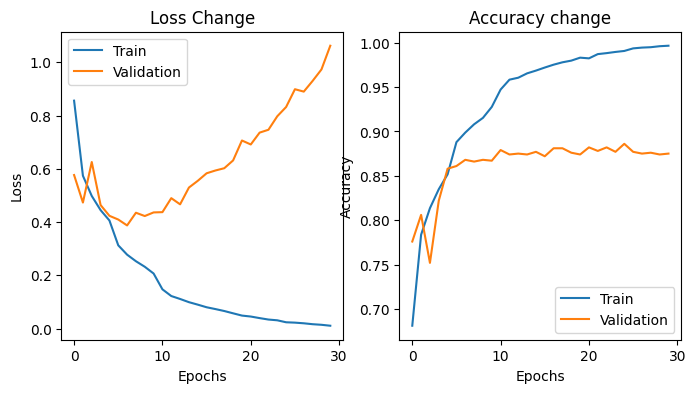

In [48]:
plot_curves(cnn_2_history)

## Comparison

In [55]:
print(f"|{'name':<200}|{'test_acc':<10}|{'test loss':<10}|{'learning time':<15}|")
for i in ['simple', 'cnn', 'cnn_2']:
    model_name = 'name_' + str(i) + '_model'
    model_test_acc = 'test_acc_' + str(i)  + '_model'
    model_test_loss = 'test_loss_' + str(i) + '_model'
    model_learning_time = 'end_' + str(i) + '_model'
    print()
    print(f"|{globals()[model_name]:<200}|{f'{globals()[model_test_acc]:.5f}':<10}|{f'{globals()[model_test_loss]:.5f}':<10}|{f'{globals()[model_learning_time]:.2f}':<15}|")

|name                                                                                                                                                                                                    |test_acc  |test loss |learning time  |

|Simple Adam - Hidden Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  15 epochs,  batch = 2                                                                              |0.92840   |0.20611   |503.08         |

|CNN Adam - Hidden Conv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  15 epochs,  batch = 2            |0.97030   |0.11899   |570.59         |

|CNN_2 Adam - Hidden Conv2D(32) + MP(2x2) + Conv2D(64) + MP(2x2) + Conv2D(64) + MP(2x2) + Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  30 epochs,  batch = 2          |0.98360   |0.12422   |1795.48        |


З поміж усіх моделей, які в попередньму домашньому завданні змогли досігти точності, вищої за 91%, була обрана для подальшого порівняння модель з найкращім результатом:


№50 - 92% на тестовому наборі (Adam - Hidden Sigm (256) + Tanh (128) + Drop (0.2) + ReLU (64) + Output Softmax (10) - LRS -  15 epochs,  batch = 2) 

В цій роботі ця модель була перейменована в simple_model

З метою чистоти порівняння, загальна структура коду не змінювалася.

Шляхом додавання Convolution + MaxPooling до тієї самої структури з повнозв'язних шарів вдадося отримати приріст точності на майже 4% (з 92,8% до 97%), криві навчання стали помітно гладкішими, але графіки  loss та accuracy дозволяють припустити подальше збільшення точності. Тому для порівняння був додан ще один експеримент зі збільшенням кількості епох вдвічі (з 15 до 30)

Це збільшило точність моделі до 98,36% на тестових даних

# HomeWork Part 2